In [1]:
import numpy as np
import pandas as pd
import graphviz
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from IPython.display import Image
from gp_explainer.gpx import Gpx
from sklearn.naive_bayes import GaussianNB
from matplotlib.colors import ListedColormap
import matplotlib.image as mpimg
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.datasets import make_moons, make_circles, make_classification

In [2]:
classifiers = {"Decision_Tree": DecisionTreeClassifier(max_depth=5),
               "Neural_Net": MLPClassifier(alpha=1, max_iter=1000),
               "Random_Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)}

In [3]:
datasets = {'moons': make_moons(noise=0.3, random_state=0, n_samples=1000),
            'circles': make_circles(noise=0.3, factor=0.5, n_samples=1000),
            'make_classification': make_classification(n_features=2, n_redundant=0, n_informative=2, 
                                n_clusters_per_class=1, n_samples=1000)}

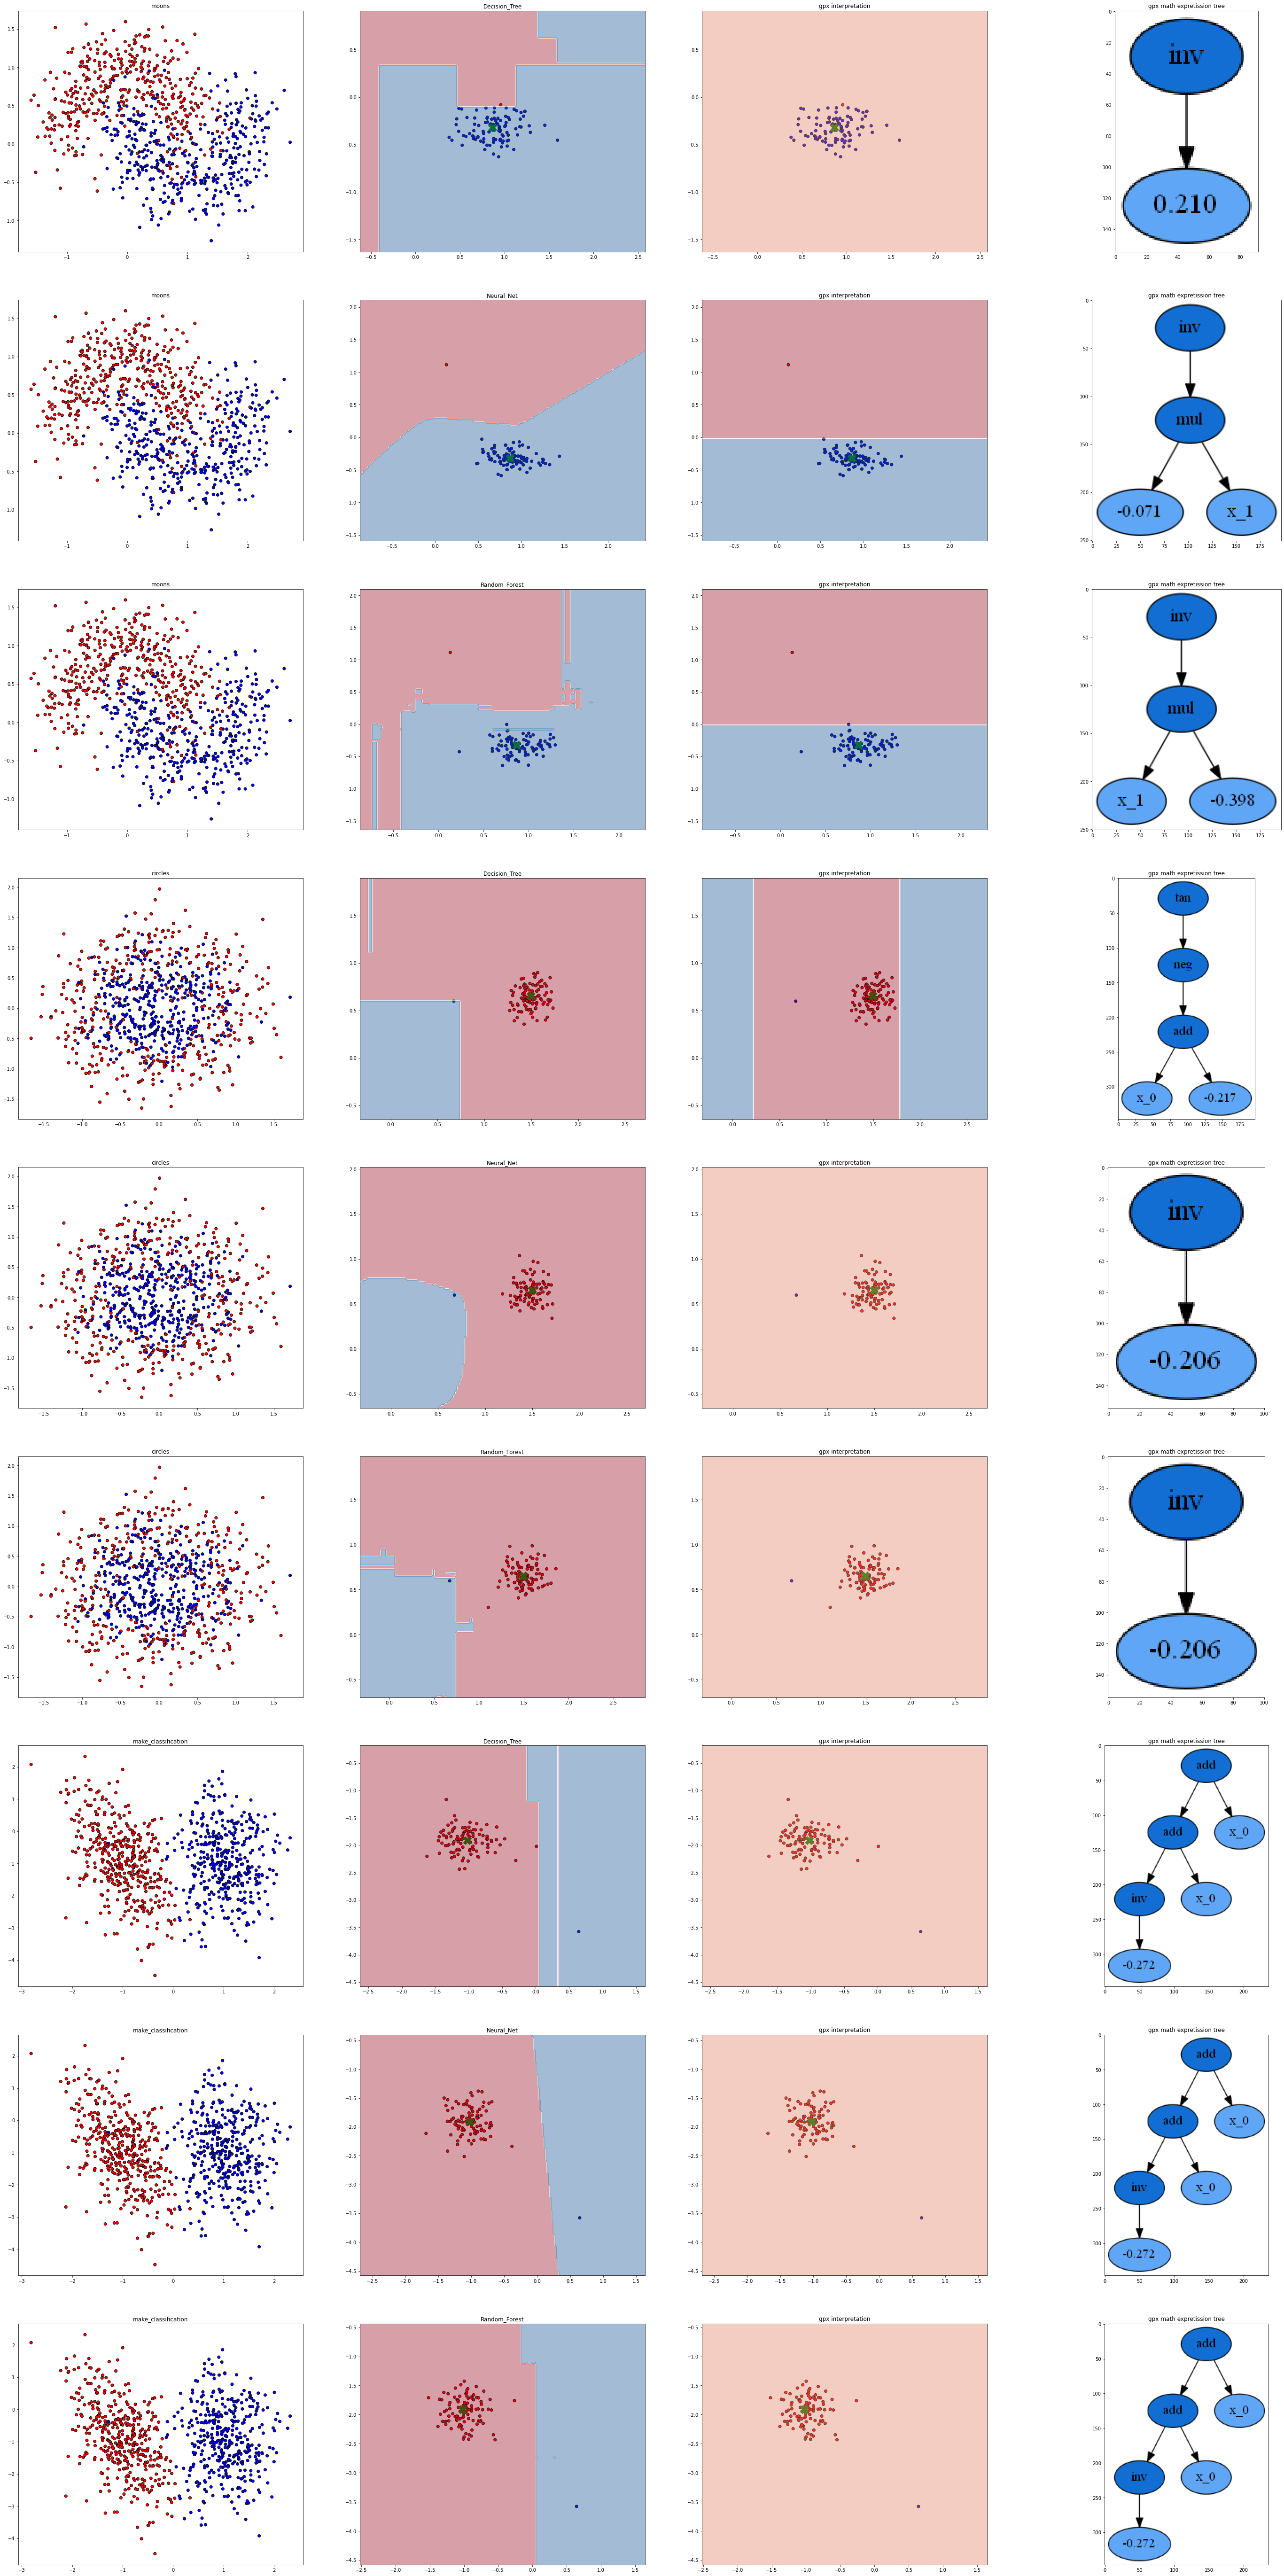

In [4]:
fig = plt.figure(figsize=(50,100))
count_fig = 0
for ds_name, data in datasets.items():
    
    x, y = data
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.8, test_size=.2)
    instance = x_test[np.random.randint(x_test.shape[0]), :]
    
    for model_name, model in classifiers.items():
        
        model.fit(x_train, y_train)
        gpx = Gpx(model.predict, x_train=x_train, y_train=y_train, num_samples=100)
        
        my_exp, x_around, y_around = gpx.explaining(instance)
        
        cm, cm_bright = plt.cm.RdBu, ListedColormap(['#FF0000', '#0000FF']) # just plot the dataset first
        
        count_fig+=1
        ax = plt.subplot(len(datasets) * len(classifiers), 4, count_fig)        
        ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')   
        ax.set_title(ds_name)
        
        resolution = 0.02
        x1_min, x1_max = x_around[:, 0].min() - 1, x_around[:, 0].max() + 1
        x2_min, x2_max = x_around[:, 1].min() - 1, x_around[:, 1].max() + 1
        xm1, xm2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
        
        x_c = np.vstack((x_around, instance))
        y_c = np.concatenate((y_around, my_exp), axis=None)
        
        c4 = (y_c == 3)*200
        c4[-1] = 300
        
        count_fig+=1
        ax = plt.subplot(len(datasets) * len(classifiers), 4, count_fig) 
        ax.scatter(x_c[:, 0], x_c[:, 1], c=y_c, cmap=cm_bright, edgecolors='k')                        
        ax.scatter(x_c[:, 0], x_c[:, 1],  color='g', s=c4,  marker='X')
        Z_bb = gpx.predict(np.array([xm1.ravel(), xm2.ravel()]).T)
        ax.contourf(xm1, xm2, Z_bb.reshape(xm1.shape), alpha=0.4, cmap=cm)
        ax.set_title(model_name)

        count_fig+=1
        ax = plt.subplot(len(datasets) * len(classifiers), 4, count_fig) 
        ax.scatter(x_c[:, 0], x_c[:, 1], c=y_c, cmap=cm_bright, edgecolors='k')                        
        ax.scatter(x_c[:, 0], x_c[:, 1],  color='g', s=c4,  marker='X')
        Z_gp = gpx.gp_model.predict(np.array([xm1.ravel(), xm2.ravel()]).T)
        ax.contourf(xm1, xm2, Z_gp.reshape(xm1.shape), alpha=0.4, cmap=cm)
        ax.set_title('gpx interpretation')

        
        count_fig+=1
        ax = plt.subplot(len(datasets) * len(classifiers), 4, count_fig) 
        graph = gpx.make_graphviz_model()
        graph.write_png('image/'+model_name+'_'+ds_name +'.png')
        ax.imshow(mpimg.imread('image/'+model_name+'_'+ds_name +'.png'))
        ax.set_title('gpx math expretission tree')